<a href="https://colab.research.google.com/github/wavesoumen/Phishing_Website_Detection/blob/main/Phishing_URL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = 'drive/My Drive/HACKATHON'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
data_file= pd.read_csv(Path+'/combined_dataset.csv')

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Importing Libraries....

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [ ]:
data_file

,domain,ranking,isIp,valid,activeDuration,urlLen,isat,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www.voting-yahoo.com,10000000,0,0,0,20,0,0,1,20,2,1
1,www.zvon.org/xxl/WSDL1.1/Output/index.html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais.com/file-security-update-infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima.astro.umd.edu/nemo/linuxastro/,7001,0,0,0,35,0,0,0,18,3,0
4,huarui-tec.com/js/?us.battle.net/login/en/?ref...,10000000,0,1,730,79,0,0,1,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95905,www.freewebs.com/ryanrules2/,5001,0,1,8035,28,0,0,0,16,2,0
95906,www.ireland-information.com/freecelticfonts.htm,230251,0,1,8400,47,0,0,1,27,2,0
95907,www.clubtaunus.soroptimist.de/img/pro/e.php,10000000,0,0,0,43,0,0,0,29,3,1
95908,www.askmen.com/sports/business/index.html,2008,0,1,9862,41,0,0,0,14,2,0


In [ ]:
data_file.head(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,isat,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www.voting-yahoo.com,10000000,0,0,0,20,0,0,1,20,2,1
1,www.zvon.org/xxl/WSDL1.1/Output/index.html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais.com/file-security-update-infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima.astro.umd.edu/nemo/linuxastro/,7001,0,0,0,35,0,0,0,18,3,0
4,huarui-tec.com/js/?us.battle.net/login/en/?ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [ ]:
data_file.isna().any()

domain            False
ranking           False
isIp              False
valid             False
activeDuration    False
urlLen            False
isat              False
isredirect        False
haveDash          False
domainLen         False
nosOfSubdomain    False
label             False
dtype: bool

In [ ]:
#Checking the distribution of data
print(data_file['label'].value_counts())
print(data_file.shape)

1    55914
0    39996
Name: label, dtype: int64
(95910, 12)


**Cleaning and preprocessing**

In [ ]:
def remove_characters(row):
    chars = re.escape(string.punctuation)
    return re.sub(r'['+chars+']', ' ',row)

data_file['domain'] = data_file['domain'].apply(remove_characters)

In [ ]:
data_file.head(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,isat,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www voting yahoo com,10000000,0,0,0,20,0,0,1,20,2,1
1,www zvon org xxl WSDL1 1 Output index html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais com file security update infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima astro umd edu nemo linuxastro,7001,0,0,0,35,0,0,0,18,3,0
4,huarui tec com js us battle net login en ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [ ]:
#Creating string for Wordcloud of 'domain' tokens
comment_words = '' 
stopwords = set(STOPWORDS) 
for val in data_file['domain']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords=stopwords,
                min_font_size = 10).generate(comment_words)

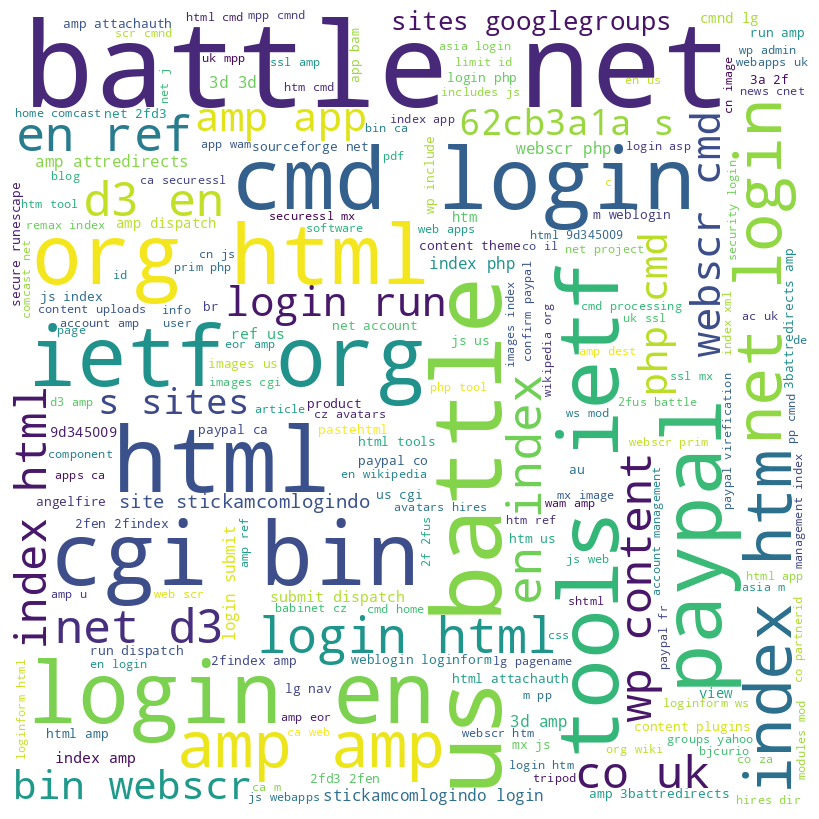

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
data_file.shape

(95910, 12)

Trying New....

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

In [ ]:
# data_file['label'] = encoder.fit_transform(data_file['label'])

In [ ]:
# data_file.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,isat,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www voting yahoo com,10000000,0,0,0,20,0,0,1,20,2,1
1,www zvon org xxl WSDL1 1 Output index html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais com file security update infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima astro umd edu nemo linuxastro,7001,0,0,0,35,0,0,0,18,3,0
4,huarui tec com js us battle net login en ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [ ]:
# # Set target variable as X and the remaining variables except Nationality and International as Y
# X = data_file.drop(columns=['domain','ranking','label'], axis=1)
# Y = data_file['label']

In [ ]:
# print(X, X.shape)

       isIp  valid  activeDuration  urlLen  isat  isredirect  haveDash  \
0         0      0               0      20     0           0         1   
1         0      1            7305      42     0           0         0   
2         0      0               0     155     0           0         0   
3         0      0               0      35     0           0         0   
4         0      1             730      79     0           0         1   
...     ...    ...             ...     ...   ...         ...       ...   
95905     0      1            8035      28     0           0         0   
95906     0      1            8400      47     0           0         1   
95907     0      0               0      43     0           0         0   
95908     0      1            9862      41     0           0         0   
95909     0      0               0     323     0           0         0   

       domainLen  nosOfSubdomain  
0             20               2  
1             12               2  
2     

In [ ]:
# print(Y, Y.shape)

0        1
1        0
2        1
3        0
4        1
        ..
95905    0
95906    0
95907    1
95908    0
95909    1
Name: label, Length: 95910, dtype: int64 (95910,)


In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import matplotlib.pyplot as plt # data visualization
# import plotly.graph_objects as go
# import plotly.express as px
# import seaborn as sns # data visualization

# import xgboost as xgb
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score

# import pickle 

# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

End of Trying....****

In [ ]:
data_file_x = data_file.drop(['label'], axis=1)
data_file_y = data_file['label']

In [ ]:
#Dividing the dataset into train, val and test datasets
train_df_x = data_file_x[:60000]
train_df_y = data_file_y[:60000]
val_df_x = data_file_x[60000:78000]
val_df_y = data_file_y[60000:78000]
test_df_x = data_file_x[78000:]
test_df_y = data_file_y[78000:]

In [ ]:
train_domain = train_df_x['domain']
val_domain = val_df_x['domain']
test_domain = test_df_x['domain']

In [ ]:
#Drop 'domain' from dataset since we are converting it into bag of words
train_df_x = train_df_x.drop(['domain'], axis=1)
val_df_x = val_df_x.drop(['domain'], axis=1)
test_df_x = test_df_x.drop(['domain'], axis=1)

In [ ]:
print(train_df_x.shape, val_df_x.shape, test_df_x.shape)
print(train_df_y.shape, val_df_y.shape, test_df_y.shape)

(60000, 10) (18000, 10) (17910, 10)
(60000,) (18000,) (17910,)


Bag Of **Words**

In [ ]:
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(train_domain)
X_val_bow = count_vect.transform(val_domain)
X_test_bow = count_vect.transform(test_domain)
# feature_names_bow = count_vect.get_feature_names()
print(X_train_bow.shape)
print(X_val_bow.shape)
print(X_test_bow.shape)

(60000, 75926)
(18000, 75926)
(17910, 75926)


In [ ]:
#Stacking the BoW features and other features from dataset
bow_final_train_x = hstack((X_train_bow, train_df_x))
bow_final_val_x = hstack((X_val_bow, val_df_x))
bow_final_test_x = hstack((X_test_bow, test_df_x))

In [ ]:
#Final shape of dataset will be 75926 features of domain plus 10 features of dataset. Therefore 75936 features
bow_final_train_x.shape
bow_final_val_x.shape
bow_final_test_x.shape

(17910, 75936)

**Random Forest on Bag of Words dataset**

In [ ]:
# X = data_file.drop(columns=['domain','label'], axis=1)
# Y = data_file['label']

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score

# import pickle 

# import warnings
# warnings.filterwarnings('ignore')
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [ ]:
# print(X.shape, X_train.shape, X_test.shape)

In [ ]:
# clf = RandomForestClassifier(max_depth=10, random_state=0)

# clf.fit(X_train,Y_train)
# Y_pred = clf.predict(X_test)
# print("Without Scaling and without CV: ",accuracy_score(Y_test,Y_pred))
# scores = cross_val_score(clf, X_train, Y_train, cv=10)
# print("Without Scaling and With CV: ",scores.mean())

In [ ]:
X_train_val = vstack((bow_final_train_x, bow_final_val_x))
Y_train_val = pd.concat([train_df_y, val_df_y], axis= 0)

In [ ]:
param_grid = {
 'max_depth': [4, 8, 16, 32],
 'n_estimators': [1, 2, 5, 10, 50, 100, 200]
}
t1 = datetime.datetime.now()
rf = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
clf.fit(X_train_val,Y_train_val)
print("time required = ", datetime.datetime.now() - t1)

time required =  0:18:39.166487


In [ ]:
clf.best_params_

{'max_depth': 32, 'n_estimators': 200}

In [ ]:
rf_clf = RandomForestClassifier(max_depth = clf.best_params_['max_depth'], 
                                n_estimators=clf.best_params_['n_estimators'])
rf_clf.fit(X_train_val,Y_train_val)
bow_test_proba = rf_clf.predict_proba(bow_final_test_x)
bow_train_proba = rf_clf.predict_proba(X_train_val)
print("Train proba", bow_train_proba)
print("Test proba", bow_test_proba)

Train proba [[0.45166487 0.54833513]
 [0.67889771 0.32110229]
 [0.14405309 0.85594691]
 ...
 [0.46944384 0.53055616]
 [0.67114338 0.32885662]
 [0.70679648 0.29320352]]
Test proba [[0.11643007 0.88356993]
 [0.58904099 0.41095901]
 [0.65873754 0.34126246]
 ...
 [0.37398946 0.62601054]
 [0.63277008 0.36722992]
 [0.10088279 0.89911721]]


In [ ]:
# print("Top 20 Important Features")
# d = sorted(list(zip(count_vect.get_feature_names(), rf_clf.feature_importances_ )), key=lambda x: x[1], reverse=True)[:20]
# features_list = []
# for (i,j) in d:
#     features_list.append(i)
# print(features_list)

In [ ]:
#calculatinf the AUC
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train_val, bow_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(test_df_y, bow_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print("Train AUC", bow_train_auc)
print("Test AUC", bow_test_auc)

Train AUC 0.9916176919622951
Test AUC 0.990144183939454


THE ACU IS HERE....**bold text**

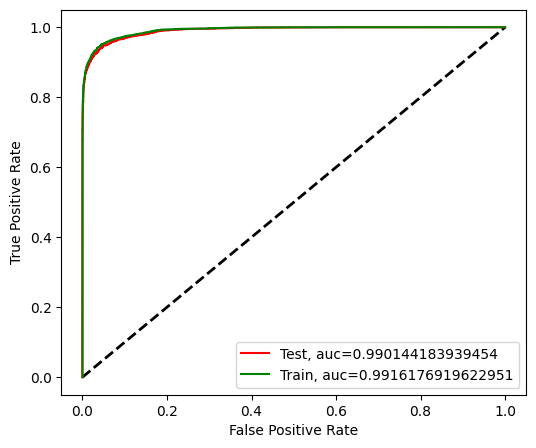

In [ ]:
import pylab
plt.figure(figsize=(6,5))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [ ]:
#Making predictions
bow_test_conf = rf_clf.predict(bow_final_test_x)
bow_train_conf = rf_clf.predict(X_train_val)

In [ ]:
#Confusion Matrix and classification report
bow_train_conf_matrix = confusion_matrix(Y_train_val, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(test_df_y, bow_test_conf)
class_report = classification_report(test_df_y, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 6634   754]
 [  323 10199]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      7388
           1       0.93      0.97      0.95     10522

    accuracy                           0.94     17910
   macro avg       0.94      0.93      0.94     17910
weighted avg       0.94      0.94      0.94     17910



Training the Confusion **Matrix**

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

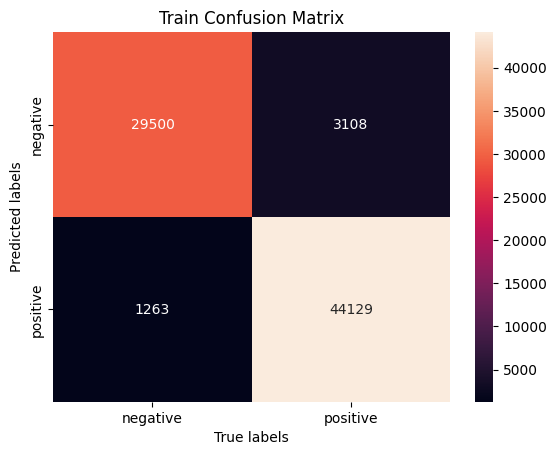

In [ ]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')
ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

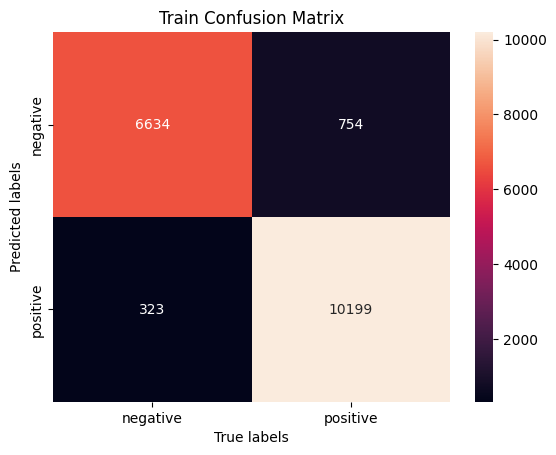

In [ ]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')
ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Algorithm", "Max_depth", "n_estimators",  "Vectorizer", "Train", "Test"]

x.add_row(["Random Forest", 32, 200, "BoW", 0.9919, 0.9903])
print(x)

+---------------+-----------+--------------+------------+--------+--------+
|   Algorithm   | Max_depth | n_estimators | Vectorizer | Train  |  Test  |
+---------------+-----------+--------------+------------+--------+--------+
| Random Forest |     32    |     200      |    BoW     | 0.9919 | 0.9903 |
+---------------+-----------+--------------+------------+--------+--------+
